In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from collections import deque

In [37]:
def graph_plot(graph):
    edges = []
    for node, neighbors in graph.items():
        for neighbor in neighbors:
            if (neighbor, node) not in edges:
                edges.append((node, neighbor))

    G = nx.Graph()
    G.add_nodes_from(graph.keys())
    G.add_edges_from(edges)

    pos = nx.spring_layout(G)

    nx.draw(G, pos, with_labels=True, node_color='lightblue', edge_color='gray')
    plt.show()

## Поиск компонент связности
Дан граф. Необходимо подсчитать
количество компонент связности.

- Необходимо последовательно запускать
dfs от каждой не посещенной вершины.
- Заводим массив visited для отслеживания
посещения вершин
- Если после запуска dfs в графе есть
вершины, которых нет в массиве visited,
то запускаем от любой такой вершины
обход в глубину
- После каждого запуска dfs
инкрементируем счетчик количества
компонент связности

[[1, 2, 3], [4, 7, 5, 6], [8, 10, 9, 11]] всего компонент связности: 3


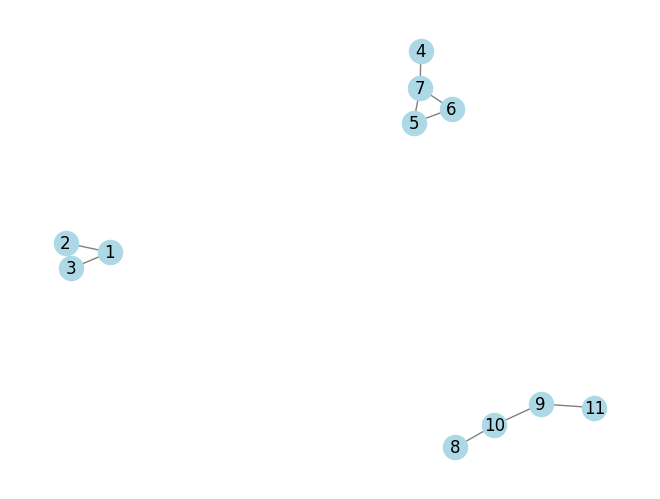

In [38]:
def dfs(graph, v, visited, component):
    visited[v] = True
    component.append(v)
    for neighbor in graph[v]:
        if not visited[neighbor]:
            dfs(graph, neighbor, visited, component)

def find_connected_components(graph):
    visited = {node: False for node in graph}
    connected_components = []

    for node in graph:
        if not visited[node]:
            component = []
            dfs(graph, node, visited, component)
            connected_components.append(component)
    return connected_components, f'всего компонент связности: {len(connected_components)}'

graph = {
    1: [2, 3], 2: [1, 3], 3: [1, 2],
    4: [7], 5: [6, 7], 6: [5, 7], 7: [4, 5, 6],
    8: [10], 9: [11], 10: [8, 9], 11: [9]
}

print(*find_connected_components(graph))

graph_plot(graph)

## Поиск компонент связности. Раскраска графа

Не всегда есть смысл тащить отдельный
массив для каждой компоненты
- У нас уже есть хеш мапа visited и в ней мы
можем в качестве значения хранить “цвет”
компоненты связности


всего компонент связности: 2


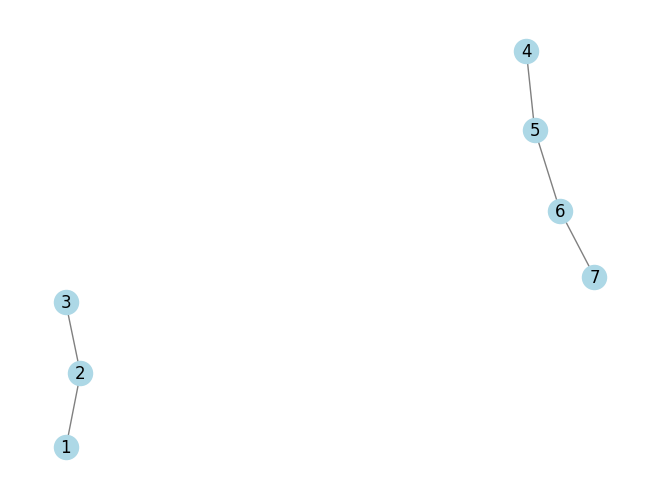

In [39]:
def dfs(graph, v, visited, color):
    visited[v] = color
    for neighbor in graph[v]:
        if visited[neighbor] == 0:
            dfs(graph, neighbor, visited, color)

def find_connected_components(graph):
    visited = {node: 0 for node in graph}
    color = 0

    for node in graph:
        if visited[node] == 0:
            color += 1
            # print(f"компонента {color}, старт с узла {node}")
            dfs(graph, node, visited, color)

    return visited, color

graph = {
    1: [2], 2: [1, 3], 3: [2],
    4: [5], 5: [4, 6], 6: [5, 7], 7: [6]
}

visited, num_components = find_connected_components(graph)
print(f"всего компонент связности: {num_components}")

# for node in sorted(visited):
#     print(f"вершина {node}: компонент {visited[node]}")

graph_plot(graph)

## Поиск цикла в графе

Дан граф в виде списка вершин. Необходимо понять, есть ли
в этом графе цикл

- DFS: Используем поиск в
глубину для обхода графа,
начиная с каждой вершины.
При этом помечаем вершины,
которые уже были посещены.
- Обнаружение обратных рёбер:
если в процессе DFS соседская
вершина уже была посещена и
при этом не является
родительской для текущей
вершины, в графе есть цикл
- Возврат результата: если при
обходе графа находится цикл,
функция возвращает True,
иначе - False.

Есть цикл


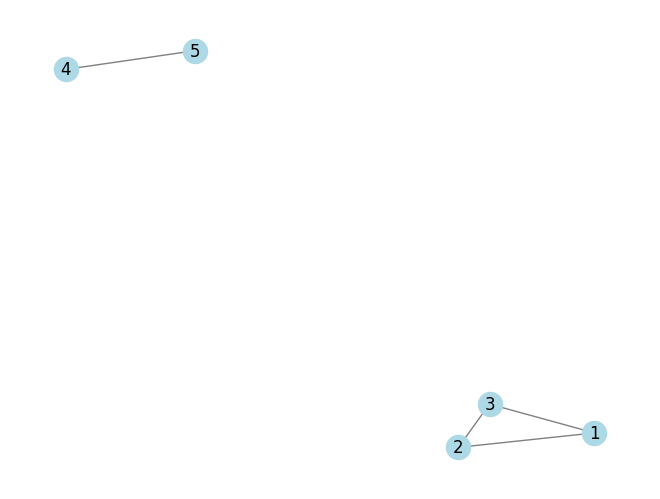

In [40]:
def has_cycle(graph):
    visited = set()

    def dfs(vertex, parent):
        visited.add(vertex)
        for neighbor in graph[vertex]:
            if neighbor != parent:
                if neighbor in visited:
                    return True
                if dfs(neighbor, vertex):
                    return True
        return False

    for vertex in graph:
        if vertex not in visited:
            if dfs(vertex, None):
                return True

    return False

graph = {
    1: [2, 3],
    2: [1, 3],
    3: [1, 2],
    4: [5],
    5: [4]
}

print("Есть цикл" if has_cycle(graph) else "Циклов нет")

graph_plot(graph)

## Является ли граф деревом

- Граф не должен
содержать циклов
- Должен состоять из
одной компоненты
связности
- Решаем через BFS

Граф — не дерево


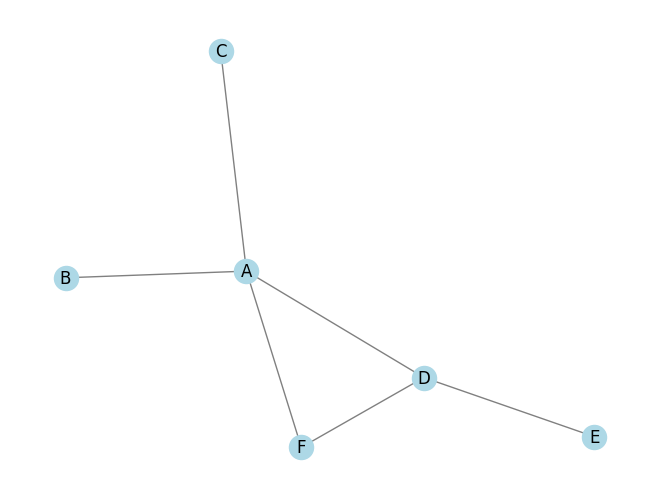

In [41]:
def is_tree(graph, start):
    visited = set()
    queue = [start]
    parent = {start: None}

    while queue:
        vertex = queue.pop(0)
        visited.add(vertex)

        for neighbor in graph[vertex]:
            if neighbor not in visited:
                queue.append(neighbor)
                parent[neighbor] = vertex
            else:
                # Если сосед уже посещён и это не родитель — найден цикл
                if parent[vertex] != neighbor:
                    return False

    # Проверка связности: все вершины должны быть посещены
    return len(visited) == len(graph)

graph = {
    'A': ['B', 'C', 'D', 'F'],
    'B': ['A'],
    'C': ['A'],
    'D': ['A', 'E', 'F'],
    'E': ['D'],
    'F': ['A', 'D']
}

print("Граф — дерево" if is_tree(graph, 'A') else "Граф — не дерево")

graph_plot(graph)

## Алгоритм Дейкстры. Поиск кратчайшего пути

- Каждой вершине проставляем
значения - минимальный вес
рёбер, которые нужно пройти,
чтобы попасть в нее из
стартовой вершины.
- Пока не начали проход по графу,
эти значения имеют
максимально возможные
значения.
- Стартовая вершина имеет
значение 0.
- Задача: при проходе обновлять
эти значения.

{'A': 0, 'B': 1, 'C': 3, 'D': 4}


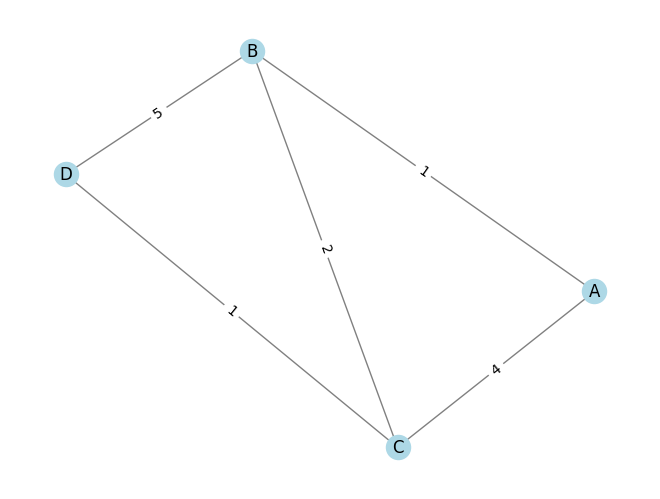

In [42]:
import heapq

def dijkstra(graph, start):
    distances = {vertex: float('infinity') for vertex in graph} # инициализация расстояний -> все бесконечность, кроме стартовой вершины
    distances[start] = 0

    priority_queue = [(0, start)]  # очередь с приоритетом (минимальное расстояние, вершина)

    while priority_queue:
        current_distance, current_vertex = heapq.heappop(priority_queue)

        if current_distance > distances[current_vertex]: # если мы уже знаем более короткий путь — пропускаем
            continue

        for neighbor, weight in graph[current_vertex]: # проверяем всех соседей
            distance = current_distance + weight
            if distance < distances[neighbor]: # если нашли более короткий путь к соседу — обновляем
                distances[neighbor] = distance
                heapq.heappush(priority_queue, (distance, neighbor))

    return distances

graph = {
    'A': [('B', 1), ('C', 4)],
    'B': [('A', 1), ('C', 2), ('D', 5)],
    'C': [('A', 4), ('B', 2), ('D', 1)],
    'D': [('B', 5), ('C', 1)]
}

result = dijkstra(graph, 'A')
print(result)

edges = []
for node in graph:
    for neighbor, weight in graph[node]:
        if (neighbor, node, weight) not in edges:
            edges.append((node, neighbor, weight))

G = nx.Graph()
G.add_weighted_edges_from(edges)

pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_color='lightblue', edge_color='gray')
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
plt.show()

## Проверка на двудольность

Дан неориентированный граф. Необходимо написать
функцию, которая вернет true, если граф является
двудольным.

### Двудольный граф

Граф является двудольным, если его вершины можно разбить на
два множества (условно, A и B), так что:
- Каждое ребро соединяет вершину из A с вершиной из B.
- Нет рёбер между вершинами одного множества.

_____________________________
- Временная сложность: O(V+E), где V — количество вершин, E -
количество рёбер. Мы проходим каждую вершину и ребро один
раз.
- Пространственная сложность: O(V), для хранения цвета и
очереди BFS.

True


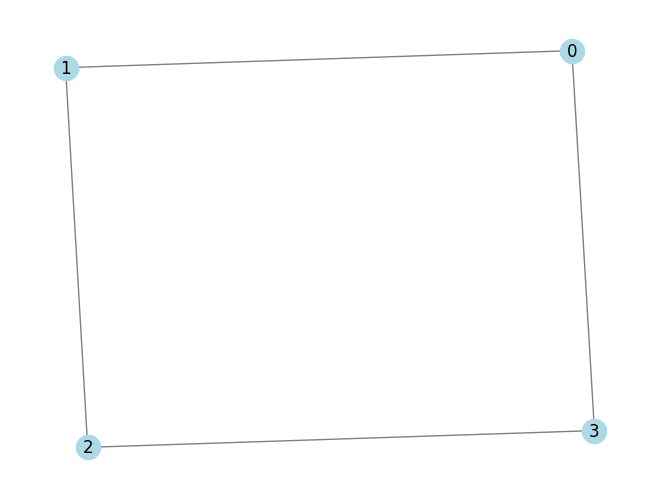

In [43]:
from collections import deque

def is_bipartite(graph):
    n = len(graph)
    colors = [0] * n  # 0 — не раскрашена, 1 и -1 — два "цвета"

    def bfs(start):
        queue = deque([start])
        colors[start] = 1  # Красим начальную вершину

        while queue:
            node = queue.popleft()
            for neighbor in graph[node]:
                if colors[neighbor] == 0:
                    colors[neighbor] = -colors[node]  # противоположный цвет
                    queue.append(neighbor)
                elif colors[neighbor] == colors[node]:
                    return False  # конфликт цветов → граф не двудольный
        return True

    for i in range(n):
        if colors[i] == 0:
            if not bfs(i):
                return False

    return True

graph = {
    1:[0, 2],
    2:[1, 3],
    3:[2, 0],
    0:[3, 1]
}

print(is_bipartite(graph))

graph_plot(graph)